# Post-WTMM analysis of terminus positions

By Jukes Liu (jukesliu@boisestate.edu)

_Last modified 06-12-2020._

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import subprocess
import fiona
from shapely.geometry import Polygon, Point
import shapely

basepath = '/home/jukes/Documents/Sample_glaciers/'

os.chdir('/home/jukes/automated-glacier-terminus')
from automated_terminus_functions import midpoint

FileNotFoundError: [Errno 2] No such file or directory: '/home/jukes/automated-glacier-terminus'

### Grab the BoxIDs

In [2]:
downloaded_df = pd.read_csv(basepath+'Images_downloaded_SE_focus.csv', sep=',', dtype=str)
downloaded_df = downloaded_df.set_index('BoxID')
# # pathrows_df = pathrows_df.drop('215')
# pathrows_df
BoxIDs = list(downloaded_df.index)
print(BoxIDs)

['245', '296', '220', '240', '277', '270', '246']


# 1) Grab the vertices of the glacier terminus boxes in pixel coordinates

The vertices of the glacier terminus box will be used to calculate a midpoint of the left edge of the terminus box, which will be our reference point for calculating terminus position.

In [128]:
# convert rasterized, rotated boxes to shapefiles:
for BoxID in BoxIDs:
#     if BoxID == '270':
        boxpath = "/media/jukes/jukes1/LS8aws/Box"+BoxID+"/rotated_c1/R_Box"+BoxID+"_raster_cut"
        polygonize='gdal_polygonize.py '+boxpath+'.pgm -f "ESRI Shapefile" '+boxpath+'.shp'
        subprocess.call(polygonize, shell=True)

In [175]:
# # read in box shapefile:
# termboxes = {}
# for BoxID in BoxIDs:
#     print("Box"+BoxID)
#     boxpath = "/media/jukes/jukes1/LS8aws/Box"+BoxID+"/rotated_c1/R_Box"+BoxID+"_raster_cut"
#     termbox = fiona.open(boxpath+'.shp'); box = termbox.next()
#     box_geom= box.get('geometry'); box_coords = box_geom.get('coordinates')[0]  
    
#     xs = list(zip(*box_coords))[0]; ys = list(zip(*box_coords))[1]
    
# #     plt.plot(xs, ys)
# #     plt.gca().invert_yaxis(); plt.axis('scaled'); plt.show()
    
#     vertices = []
    
#     if BoxID =='270':
#         print(xs)
#         print(np.where(xs == np.max(xs))[0])
#     elif BoxID == '296':
#         # grab minimum x
#         min_x_i = np.where(xs == np.min(xs))[0][0]
#         print(np.where(xs == np.min(xs))[0])
#         for xi in np.where(xs == np.min(xs))[0]:
#             print(ys[xi])
#         print(xs[min_x_i], ys[min_x_i])
#         vertices.append(shapely.geometry.Point(xs[min_x_i], ys[min_x_i]))
#     else:
#         # grab minimum x
#         min_x_i = np.where(xs == np.min(xs))[0][0]
#         minx_x = xs[min_x_i]; minx_y = ys[min_x_i]
        
#         vertices.append(shapely.geometry.Point(xs[min_x_i], ys[min_x_i]))
#         # grab maximum y
#         max_y_i = np.where(ys == np.max(ys))[0][-1]
# #         print(xs[max_y_i], ys[max_y_i])
#         vertices.append(shapely.geometry.Point(xs[max_y_i], ys[max_y_i]))
#         # grab maximum x
#         max_x_i = np.where(xs == np.max(xs))[0][-1]
# #         print(xs[max_x_i], ys[max_x_i])
#         vertices.append(shapely.geometry.Point(xs[max_x_i], ys[max_x_i]))
#         # grab minimum y
#         min_y_i = np.where(ys == np.min(ys))[0][0]
# #         print(xs[min_y_i], ys[min_y_i])
#         vertices.append(shapely.geometry.Point(xs[min_y_i], ys[min_y_i]))

    
#     boxshp = shapely.geometry.Polygon(vertices)
#     termboxes.update({BoxID: boxshp})
    
# #     points = [] # to hold the vertices
# #     for coord_pair in box_coords:
# #         lat = coord_pair[0]; lon = coord_pair[1]
# #         #create shapely points and append to points list
# #         point = (lat, lon)
# #         points.append(point)
# #         print(point)
# #     termboxes.update( {BoxID: points} ); print("Box"+BoxID)

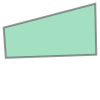

In [169]:
# termboxes['296']

In [199]:
# BoxIDs

In [209]:
#create dictionary to store each terminus box ndarray by BoxID
termboxes2 = {}

#read in the terminus box rasters
for BoxID in BoxIDs:
    #load in the raster
    boxpath = basepath+"Box"+BoxID+"/rotated_images/final/crop_Box"+BoxID+"_raster_cut.pgm"
#     boxpath = "/media/jukes/jukes1/LS8aws/Box"+BoxID+"/rotated_c1/R_Box"+BoxID+"_raster_cut.png"

    #read the raster into an ndarray
    termbox = mpimg.imread(boxpath)
    #add the ndarray into a dictionary with the BoxID as the key
    termboxes2.update( {BoxID: termbox} )

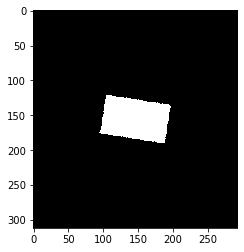

In [210]:
#visualize each terminus box rasters by BoxID
termplot = plt.imshow(termboxes2['277'])
plt.show()

#### Find x,y coordinates of box vertices and midpoints of left and right edges to get the centerline

In [216]:
#create dictionary to store the all coordinates of the box rasters
boxes_xcoords = {}; boxes_ycoords = {}

#create dictionaries for the box vertices
topleft_coords = {}; bottomleft_coords = {}; topright_coords = {} ;bottomright_coords = {}

#create lists to store the left midpoints (1C) and right midpoints (2C)
midpoints_x = []; midpoints_y = []; midpoints_r_x = []; midpoints_r_y = []
mids_l025_x = []; mids_l025_y = []; mids_r025_x = []; mids_r025_y = []
mids_l075_x = []; mids_l075_y = []; mids_r075_x = []; mids_r075_y = []

#create lists to store the slopes and intercepts of the centerline equations
slope_50 = []; intercept_50 = []; slope_25 = []; intercept_25 = []; slope_75 = []; intercept_75 = []; boxes = []

#for all the box rasters
for BoxID in BoxIDs:
    BOI = termboxes2[BoxID] #Read in the raster of the BoxID of interest
    if len(BOI.shape) > 2:
        yindices, xindices, third= np.where(BOI > 0) #keep the pixels of where the box exists
    else:
        yindices, xindices= np.where(BOI > 0) #keep the pixels of where the box exists
    boxes_ycoords.update( {BoxID: yindices}); boxes_xcoords.update( {BoxID: xindices}) #add box coordinates to the dictionary
    
    if BoxID == '259':
        topleft = [117.0, 355.0]
        bottomleft = [166.0, 426.0]
        topright = [386.0, 169.0]
        bottomright = [435.0, 239.0]
    elif BoxID == '245':
        topright = [np.max(xindices), yindices[np.where(xindices == np.max(xindices))[0][0]]]
        xy = xindices*yindices
        min_xy_i = np.where(xy == np.nanmin(xy))[0][0]  #Find the x and y pair corresponding to that lowest xy
        topleft = [xindices[min_xy_i], yindices[min_xy_i]]
        
        max_xy = np.nanmax(xy)
        max_xy_i = np.where(xy == max_xy)[0][0]
        bottomright = [xindices[max_xy_i], yindices[max_xy_i]]
        
        y_x = yindices/xindices
        max_y_x = np.nanmax(y_x) #Find the highest y/x value
        max_y_x_i = np.where(y_x == max_y_x)[0][0]
        bottomleft = [xindices[max_y_x_i], yindices[max_y_x_i]]
    elif BoxID == '220':
        xy = xindices*yindices
        min_xy_i = np.where(xy == np.nanmin(xy))[0][0]  #Find the x and y pair corresponding to that lowest xy
        topleft = [xindices[min_xy_i], yindices[min_xy_i]]
        bottomleft = [xindices[np.where(yindices == np.max(yindices))[0][0]], np.max(yindices)]
        bottomright = [np.max(xindices), yindices[np.where(xindices == np.max(xindices))[0][0]]]
        x_y = xindices/yindices
        max_x_y = np.nanmax(x_y)  # find highest x/y value
        max_x_y_i = np.where(x_y == max_x_y)[0][0]  #Find the x, y pair correpsonding to the maximum x/y using the index
        topright = [xindices[max_x_y_i], yindices[max_x_y_i]]
    elif BoxID == '277':
        topleft = [106.0, 121.0]
        topright = [197.0, 137.0]
        bottomleft = [95.0, 176.0]
        bottomright = [189.0, 190.0]
    else:
        #1A) FIND THE TOP LEFT COORDINATES (min x and min y)
        xy = xindices*yindices
        min_xy_i = np.where(xy == np.nanmin(xy))[0][0]  #Find the x and y pair corresponding to that lowest xy
        topleft = [xindices[min_xy_i], yindices[min_xy_i]]

        #2B) FIND THE BOTTOM RIGHT COORDINATES (highest x*y)
        max_xy = np.nanmax(xy)
        max_xy_i = np.where(xy == max_xy)[0][0]
        bottomright = [xindices[max_xy_i], yindices[max_xy_i]]
        
        #1B) FIND THE BOTTOM LEFT COORDINATE(highest y/x)
        y_x = yindices/xindices
        max_y_x = np.nanmax(y_x) #Find the highest y/x value
        #Find the x and y pair corresponding to that y/x using the index
        max_y_x_i = np.where(y_x == max_y_x)[0][0]
        bottomleft = [xindices[max_y_x_i], yindices[max_y_x_i]]
        
        #2A) FIND THE TOP RIGHT COORDINATES (highest x/y)
        x_y = xindices/yindices
        max_x_y = np.nanmax(x_y)  # find highest x/y value
        max_x_y_i = np.where(x_y == max_x_y)[0][0]  #Find the x, y pair correpsonding to the maximum x/y using the index
        topright = [xindices[max_x_y_i], yindices[max_x_y_i]]
        
    topleft_coords.update(  {BoxID: topleft}  )     #Add to dictionary of topleft coordinates
    bottomright_coords.update( {BoxID: bottomright})
    bottomleft_coords.update( {BoxID: bottomleft}  ) #Add to dictionary of bottomleft coordinates
    topright_coords.update( {BoxID: topright} )
    
    # 1C and 2C) CALCULATE THE MIDPOINTS USING MIDPOINT FUNCTION
    # Left
    midpoint_x, midpoint_y = midpoint(topleft[0], topleft[1], bottomleft[0], bottomleft[1])
    # Right
    midpoint_r_x, midpoint_r_y = midpoint(topright[0], topright[1], bottomright[0], bottomright[1])
    
    # GRAB 1/4th and 3/4ths lines (midpoints)
    mid_l025_x, mid_l025_y = midpoint(topleft[0], topleft[1], midpoint_x, midpoint_y)
    mid_r025_x, mid_r025_y = midpoint(topright[0], topright[1], midpoint_r_x, midpoint_r_y) 
    mid_l075_x, mid_l075_y = midpoint(bottomleft[0], bottomleft[1], midpoint_x, midpoint_y)
    mid_r075_x, mid_r075_y = midpoint(bottomright[0], bottomright[1], midpoint_r_x, midpoint_r_y)
    
    # 3) CALCULATE CENTERLINE EQUATIONS (y_intercept = y1 - m*x1)
    # 1/2 flowline
    m = (midpoint_r_y - midpoint_y)/(midpoint_r_x - midpoint_x);b = midpoint_y - (m*midpoint_x)
    # 1/4 flowline
    m025 = (mid_r025_y-mid_l025_y)/(mid_r025_x-mid_l025_x); b025 = mid_l025_y - (m*mid_l025_x)
    # 3/4 flowline
    m075 = (mid_r075_y-mid_l075_y)/(mid_r075_x-mid_l075_x); b075 = mid_l075_y - (m*mid_l075_x)
    
    # append BoxIDs, slopes, intercepts, midpoints, and centerlines to lists
    boxes.append(BoxID);
    midpoints_x.append(midpoint_x); midpoints_y.append(midpoint_y)
    midpoints_r_x.append(midpoint_r_x); midpoints_r_y.append(midpoint_r_y)  
    mids_l025_x.append(mid_l025_x); mids_l025_y.append(mid_l025_y); 
    mids_r025_x.append(mid_r025_x); mids_r025_y.append(mid_r025_y)
    mids_l075_x.append(mid_l075_x) ;mids_l075_y.append(mid_l075_y) ;
    mids_r075_x.append(mid_r075_x) ;mids_r075_y.append(mid_r075_y)
    slope_50.append(m); intercept_50.append(b); 
    slope_25.append(m025); intercept_25.append(b025)
    slope_75.append(m075); intercept_75.append(b075)
    
# create a dataframe
total_df = pd.DataFrame(list(zip(boxes, midpoints_x, midpoints_y, midpoints_r_x, midpoints_r_y, slope_50, 
                                 intercept_50, mids_l025_x, mids_l025_y, mids_r025_x, mids_r025_y, slope_25, 
                                 intercept_25, mids_l075_x, mids_l075_y, mids_r075_x, mids_r075_y, slope_75, 
                                intercept_75)), 
                        columns=['BoxID', 'lmid50_x', 'lmid50_y', 'rmid50_x','rmid50_y', 'm50', 'b50',
                                 'lmid25_x', 'lmid25_y','rmid25_x','rmid25_y', 'm25', 'b25',
                                 'lmid75_x', 'lmid75_y', 'rmid75_x','rmid75_y', 'm75', 'b75'])

total_df = total_df.drop_duplicates().set_index('BoxID')
total_df

,lmid50_x,lmid50_y,rmid50_x,rmid50_y,m50,b50,lmid25_x,lmid25_y,rmid25_x,rmid25_y,m25,b25,lmid75_x,lmid75_y,rmid75_x,rmid75_y,m75,b75
BoxID,,,,,,,,,,,,,,,,,,
245,128.5,147.5,219.5,216.0,0.752747,50.771978,140.25,131.75,231.25,200.50,0.755495,26.177198,116.75,163.25,207.75,231.50,0.750000,75.366758
296,89.0,114.5,175.5,118.0,0.040462,110.898844,89.50,102.75,175.75,106.00,0.037681,99.128613,88.50,126.25,175.25,130.00,0.043228,122.669075
220,149.5,228.5,244.5,149.5,-0.831579,352.821053,133.75,209.75,229.25,131.25,-0.821990,320.973684,165.25,247.25,259.75,167.75,-0.841270,384.668421
240,217.5,288.5,342.0,236.0,-0.421687,380.216867,199.75,247.25,324.00,194.50,-0.424547,331.481928,235.25,329.75,360.00,277.50,-0.418838,428.951807
277,100.5,148.5,193.0,163.5,0.162162,132.202703,103.25,134.75,195.00,150.25,0.168937,118.006757,97.75,162.25,191.00,176.75,0.155496,146.398649
270,110.5,163.5,206.0,149.0,-0.151832,180.277487,107.25,142.75,202.50,127.50,-0.160105,159.034031,113.75,184.25,209.50,170.50,-0.143603,201.520942
246,103.5,162.0,185.5,122.0,-0.487805,212.487805,94.75,143.50,176.25,103.50,-0.490798,189.719512,112.25,180.50,194.75,140.50,-0.484848,235.256098


### Another visual check

In [7]:
# Choose which glacier BoxID to check:
BOI_ID = '270'

# plot the raster pixels in black
plt.scatter(boxes_xcoords[BOI_ID], boxes_ycoords[BOI_ID], c='k',marker='s')
# plot the vertices
plt.scatter(topleft_coords[BOI_ID][0], topleft_coords[BOI_ID][1], c='y')
plt.scatter(bottomleft_coords[BOI_ID][0], bottomleft_coords[BOI_ID][1], c='y')
plt.scatter(topright_coords[BOI_ID][0], topright_coords[BOI_ID][1], c='y')
plt.scatter(bottomright_coords[BOI_ID][0], bottomright_coords[BOI_ID][1], c='y')
# plot midpoints
plt.scatter(total_df.at[BOI_ID,'lmid50_x'], total_df.at[BOI_ID,'lmid50_y'], c='m'); plt.scatter(total_df.at[BOI_ID, 'rmid50_x'], total_df.at[BOI_ID, 'rmid50_y'], c='m')
plt.scatter(total_df.at[BOI_ID,'lmid25_x'], total_df.at[BOI_ID,'lmid25_y'], c='r'); plt.scatter(total_df.at[BOI_ID, 'rmid25_x'], total_df.at[BOI_ID, 'rmid25_y'], c='r')
plt.scatter(total_df.at[BOI_ID,'lmid75_x'], total_df.at[BOI_ID,'lmid75_y'], c='b'); plt.scatter(total_df.at[BOI_ID, 'rmid75_x'], total_df.at[BOI_ID, 'rmid75_y'], c='b')
# plot the centerlines in cyan
x=np.linspace(np.min(boxes_xcoords[BOI_ID]), np.max(boxes_xcoords[BOI_ID])); y50=(total_df.at[BOI_ID, 'm50'])*x + (total_df.at[BOI_ID, 'b50']); 
y25=(total_df.at[BOI_ID, 'm25'])*x + (total_df.at[BOI_ID, 'b25']); y75=(total_df.at[BOI_ID, 'm75'])*x + (total_df.at[BOI_ID, 'b75'])
plt.plot(x, y50, '--m', x, y25, '--r', x, y75, '--b')
# plot parameters      
plt.gca().invert_yaxis(); plt.axis('scaled'); plt.show()

NameError: name 'boxes_xcoords' is not defined

### Drop the right midpoints and write the centerline information to a csv

In [218]:
total_df = total_df.drop(['rmid50_y', 'rmid25_y', 'rmid75_y'], axis=1)
total_df.head(10)

,lmid50_x,lmid50_y,rmid50_x,m50,b50,lmid25_x,lmid25_y,rmid25_x,m25,b25,lmid75_x,lmid75_y,rmid75_x,m75,b75
BoxID,,,,,,,,,,,,,,,
245,128.5,147.5,219.5,0.752747,50.771978,140.25,131.75,231.25,0.755495,26.177198,116.75,163.25,207.75,0.750000,75.366758
296,89.0,114.5,175.5,0.040462,110.898844,89.50,102.75,175.75,0.037681,99.128613,88.50,126.25,175.25,0.043228,122.669075
220,149.5,228.5,244.5,-0.831579,352.821053,133.75,209.75,229.25,-0.821990,320.973684,165.25,247.25,259.75,-0.841270,384.668421
240,217.5,288.5,342.0,-0.421687,380.216867,199.75,247.25,324.00,-0.424547,331.481928,235.25,329.75,360.00,-0.418838,428.951807
277,100.5,148.5,193.0,0.162162,132.202703,103.25,134.75,195.00,0.168937,118.006757,97.75,162.25,191.00,0.155496,146.398649
270,110.5,163.5,206.0,-0.151832,180.277487,107.25,142.75,202.50,-0.160105,159.034031,113.75,184.25,209.50,-0.143603,201.520942
246,103.5,162.0,185.5,-0.487805,212.487805,94.75,143.50,176.25,-0.490798,189.719512,112.25,180.50,194.75,-0.484848,235.256098


In [219]:
# change filename as desired
CLINE_NAME = 'Boxes_coords_pathrows_sample5.csv'
total_df.to_csv(path_or_buf = basepath+CLINE_NAME, sep=',')

# 2) Calculate terminus position time series

In [3]:
# IMPORT THE FUNCTION
os.chdir('/home/jukes/automated-glacier-terminus')
from automated_terminus_functions import results_allglaciers

(629, 2)
Box245
(690, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 15 dips
Dropping 48 dips
Dropping 20 dips
Dropping 19 jumps
Dropping 27 jumps
Dropping 29 jumps
117
110
120


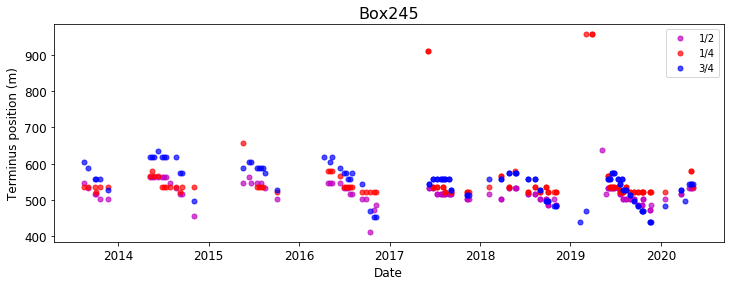

Box296
(1177, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 96 dips
Dropping 104 dips
Dropping 110 dips
Dropping 128 jumps
Dropping 141 jumps
Dropping 165 jumps
144
142
141


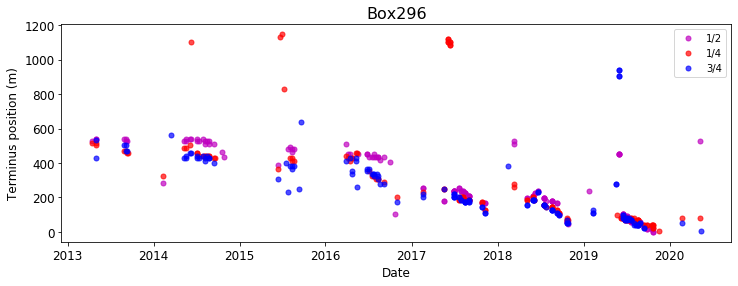

Box220
(1042, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 39 dips
Dropping 44 dips
Dropping 46 dips
Dropping 72 jumps
Dropping 47 jumps
Dropping 35 jumps
147
148
145


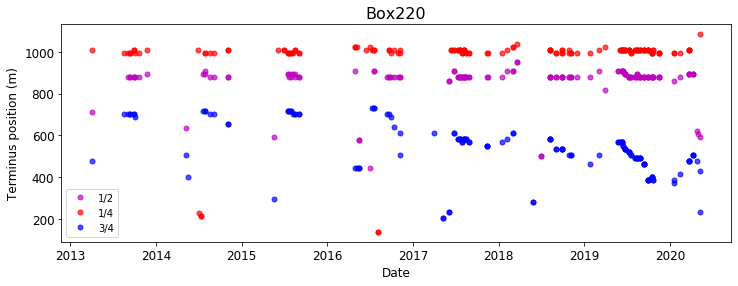

Box240
(670, 4)


KeyboardInterrupt: 

In [4]:
# Syntax:
# results_allglaciers(date_csv, centerline_csv, vel_csv, analysis_date, V, N1, N2)
# V is the flow speed scalar
# N1 is the number of iterations to remove dips
# N2 is the number of iterations to remove jumps

results_allglaciers('Images_downloaded_SE_focus.csv','imgdates_SE_focus.csv', 'Boxes_coords_pathrows_SE_focus.csv','Glacier_vel_measures_SE_focus.csv', '2020_06_03', 3, 1, 1)